In [20]:
import torch
import spacy
import numpy as np
import torchtext.vocab
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchtext import data
import torch
import torch.nn as nn
from sentiment_model.data_utils.tweet_dataset import TweetDataset, pad_batch
from sentiment_model.evaluation import run_evaluation
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import os
from utils import get_project_root
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sentiment_model.model_calibration import plot_calib_curve, CalibratedModel
from time import time
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from torch.utils.data import Subset
from itertools import combinations, product
from sklearn.model_selection import KFold
from torch.utils.data import random_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sentiment_model.model import SentimentNet
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(1,1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    labels = ['negative', 'neutral', 'positive']
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    fig.set_tight_layout(True)
    return fig

In [2]:
# Import GloVe Embeddings
# Load training dataset to build vocab
cache_path = os.path.join(get_project_root(), Path("sentiment_model/.vector_cache/"))
glove_twitter = GloVe(name="twitter.27B", dim=50, cache=cache_path)

# Instantiate vectors and ensure a 0 vector is inserted for unknown characters and padded characters
pre_embeds = glove_twitter.vectors
pre_embeds = torch.cat((torch.zeros(2, pre_embeds.shape[1]), pre_embeds))

# Load data:
valid_dataset = TweetDataset(split="valid", dataset="sent140_multi_class", pretrained_vecs=glove_twitter)
valid_y = [y for _, y in valid_dataset]

test_dataset = TweetDataset(split="test", dataset="sent140_multi_class", pretrained_vecs=glove_twitter)
test_y = [y for _, y in test_dataset]

valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True, collate_fn=pad_batch)

checkpoint_path = os.path.join(get_project_root(), Path("sentiment_model/checkpoints/"))
model_path = os.path.join(checkpoint_path, Path("lemon-aardvark-83/lemon-aardvark-83-epoch-14.pth"))

# Load checkpoint:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_path)
model = SentimentNet(vocab_size=len(test_dataset.vocab), embedding_dim=50,
                             rnn_hidden_dim=256, rnn_n_layers=2, rnn_bidirectional=True,
                             dropout_rate=0.5, num_classes=2, pretrained_embeddings=pre_embeds,
                             freeze_embed=True)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset sentiment140 (C:/Users/20172613/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)


  0%|          | 0/2 [00:00<?, ?it/s]

SentimentNet(
  (embedding): Embedding(1193516, 50)
  (rnn): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

# Calibrate 2-class model

In [3]:
CM = CalibratedModel(model)

time1 = time()
preds = CM.fit(valid_dataset, valid_y, return_model_probs=True)
time2 = time()

print(f"Fitting took {np.round(time2-time1, 2)} s")

100%|██████████| 1250/1250 [04:24<00:00,  4.73it/s]


Fitting took 264.49 s


In [4]:
calib_save_folder = os.path.join(get_project_root(), Path("sentiment_model/checkpoints/calibrated_model/"))
CM.save(calib_save_folder)

In [5]:
time1 = time()
pred_calib = CM.predict_proba(valid_dataset)
time2 = time()

print(f"Predicting calibrated probs took {np.round(time2-time1, 2)} s")

100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s]

Predicting calibrated probs took 270.38 s


As can be seen, results of calibrating on validation set looks nice:

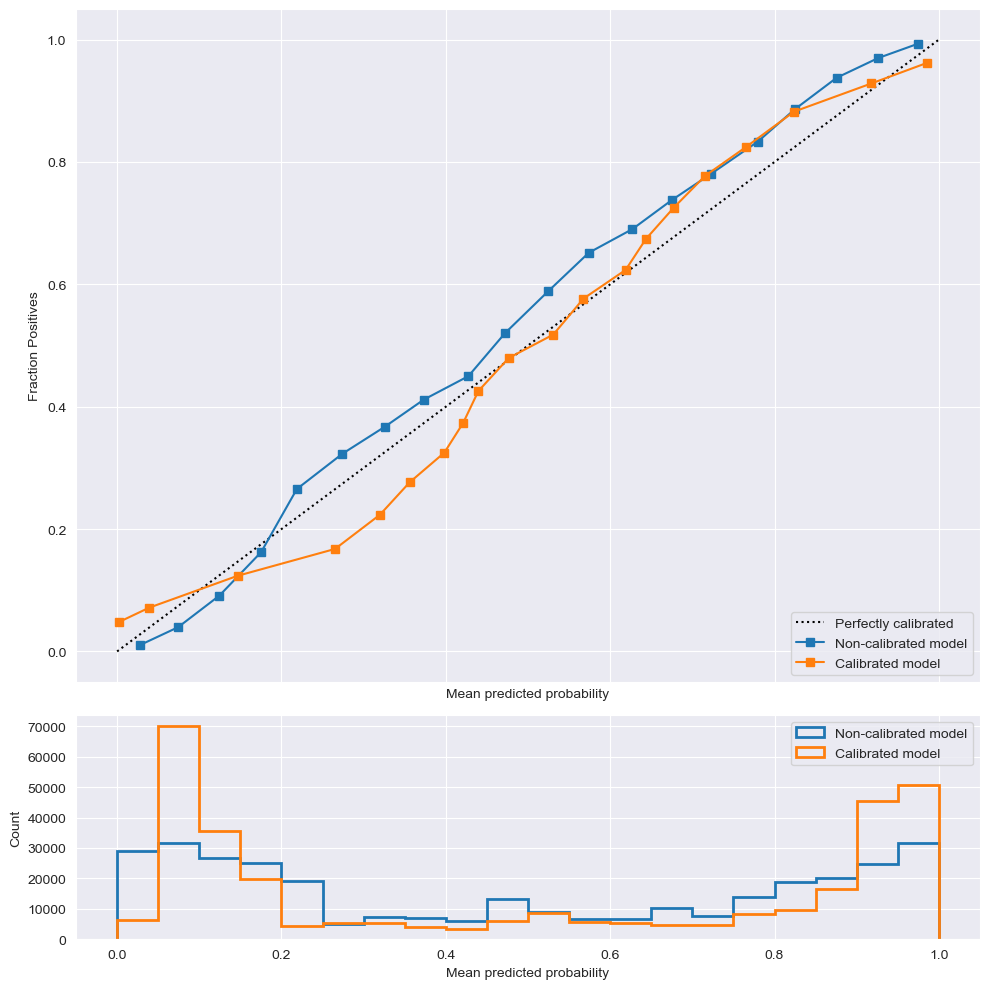

In [6]:
fig = plot_calib_curve(valid_y, preds[:,1], pred_calib[:,1])
fig.set_tight_layout(True)
fig.savefig("../visualisation/figures/calib_curve_pos.png", dpi=400)

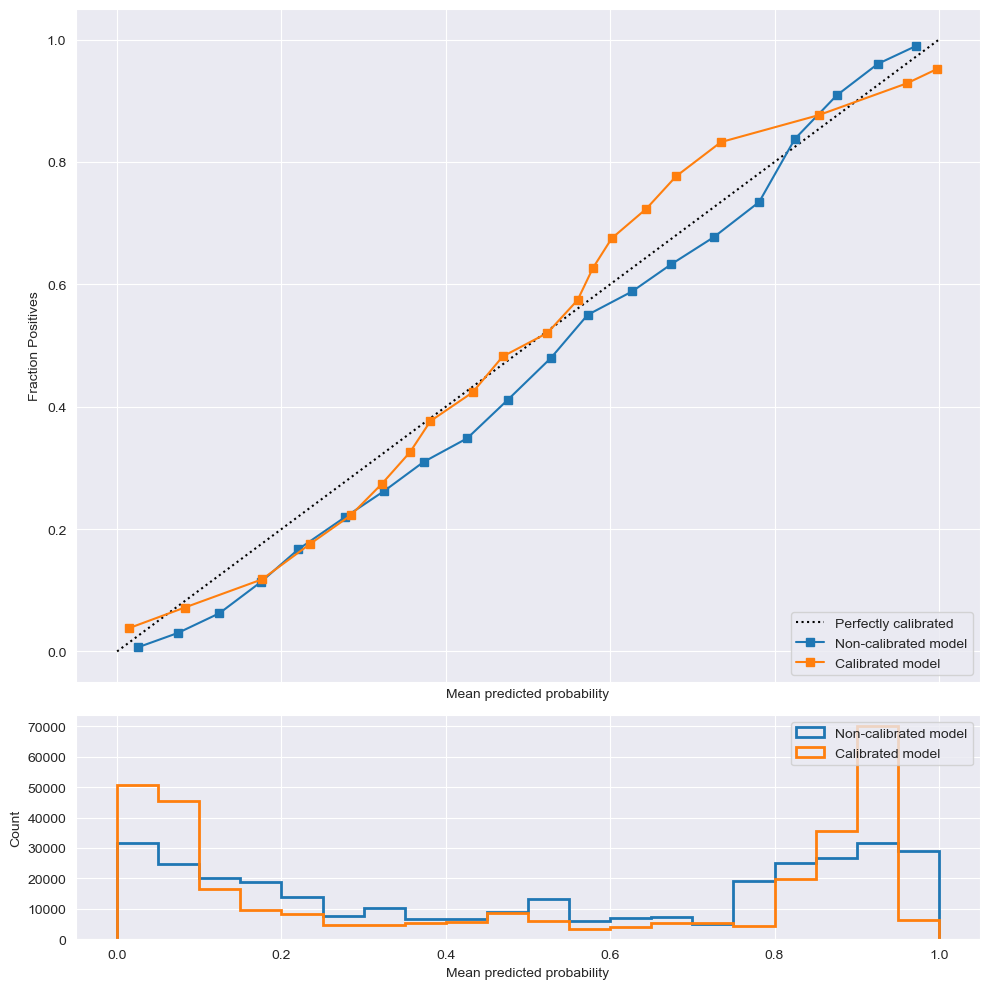

In [7]:
fig = plot_calib_curve((np.array(valid_y) == 0).astype(int), preds[:,0], pred_calib[:,0])
fig.set_tight_layout(True)
fig.savefig("../visualisation/figures/calib_curve_neg.png", dpi=400)

## Setting out of sample maxprob threshold

In [8]:
def one_hot_to_1d(arr):
    return np.argmax(arr, axis=1)

def one_hot_transform(labels_1d, unique_label_count="infer"):
    if unique_label_count == 'infer':
        unique_label_count = labels_1d.max()+1

    encoded = np.zeros((len(labels_1d), unique_label_count), dtype=int)
    encoded[np.arange(len(labels_1d)), labels_1d] = 1
    return encoded

def predict(clf, dataset, boundary):
    pred_probs = clf.predict_proba(dataset)

    if type(boundary) == tuple:
        return predict_flexible_boundary(pred_probs, boundary)

    else:
        return predict_boundary(pred_probs, boundary)

def predict_boundary(pred_probs, boundary):
    max_prob_idx = np.argmax(pred_probs, axis=1)
    max_probs = np.take_along_axis(pred_probs,max_prob_idx.reshape(-1,1),axis=1).reshape(-1)

    predictions = np.zeros(len(pred_probs), dtype=int)
    predictions[max_prob_idx > 0] = 2
    predictions[max_probs < boundary] = 1
    return predictions

def predict_flexible_boundary(pred_probs, boundary):
    b_0, b_2 = boundary
    pred_probs = np.insert(pred_probs, 1, np.zeros(len(pred_probs)), axis=1)
    # Set predicted probabilities to zero for non-maximal probs
    pred_probs[~(pred_probs == np.max(pred_probs, keepdims=True, axis=1))] = 0
    # Set predicted probabilities not reaching respective boundary to zero
    pred_probs[pred_probs[:, [0,1,2]] < np.array([b_0, 0, b_2])] = 0
    # Predicting neutral category where pos/neg not reached boundary
    pred_probs[(pred_probs == 0).all(axis=1), 1] = 1
    pred_probs[pred_probs > 0 ] = 1
    return one_hot_to_1d(pred_probs.astype(int))

def compute_decision_boundary(clf, dataset, boundaries, scorer=f1_score, scorer_args={"average":"macro"}, return_scores=False, flexible=False):
    pred_probs = clf.predict_proba(dataset)
    labels = [y for _,y in dataset]
    labels = one_hot_transform(np.array(labels))
    scores = []
    for b in boundaries:
        #print(flexible)
        if flexible:
            preds = predict_flexible_boundary(pred_probs,b)

        else:
            preds = predict_boundary(pred_probs,b)

        preds = one_hot_transform(preds, unique_label_count=labels.shape[1])
        #scores.append(roc_auc_score(labels, preds, multi_class="ovr"))
        scores.append(scorer(labels, preds, **scorer_args))
    if return_scores:
        return boundaries[np.argmax(scores)], scores
    else:
        return boundaries[np.argmax(scores)]

def dec_bound_opt(clf, dataset, boundaries, flexible=False, scorer=f1_score, scorer_args={"average":"macro"}):
    cv_split = KFold(shuffle=True, n_splits=5)

    test_scores = []

    for train_split, test_split in cv_split.split(dataset):
        train, test = Subset(dataset, train_split), Subset(dataset, test_split)
        dec_bound = compute_decision_boundary(clf, train, boundaries, flexible=flexible, scorer=scorer, scorer_args=scorer_args)
        test_pred = predict(clf, test, dec_bound)
        test_true = [y for _,y in test]
        test_scores.append(scorer(test_true, test_pred, **scorer_args))

    return test_scores

# Computing the final decision bounds

In [58]:
test_dataset_hp, test_dataset_test = random_split(test_dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(64))#64

In [59]:
sample_weight = [1 for i in range(len(test_dataset_hp))]
dec_bound, scores = compute_decision_boundary(CM, test_dataset_hp, scorer=f1_score, scorer_args={"average":"micro", "sample_weight": sample_weight}, boundaries=list(product(np.linspace(0.5, 1, 25), np.linspace(0.5, 1, 25))), flexible=True, return_scores=True)

print(f"CV Scores: {np.round(np.mean(scores), 3)} +- {np.round(np.std(scores), 3)}")
dec_bound

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


CV Scores: 0.529 +- 0.075


(0.5208333333333334, 0.7708333333333333)

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


              precision    recall  f1-score   support

           0       0.86      0.75      0.80        40
           1       0.17      0.07      0.10        29
           2       0.50      0.87      0.63        30

    accuracy                           0.59        99
   macro avg       0.51      0.56      0.51        99
weighted avg       0.55      0.59      0.54        99

0.5858585858585859


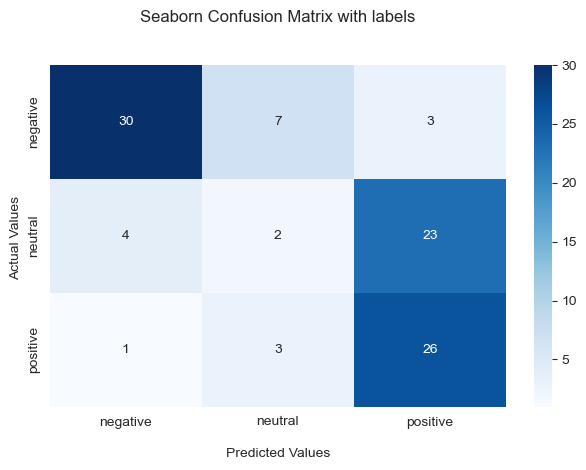

In [60]:
test_preds = predict(CM, test_dataset_test, boundary=dec_bound)
test_true = [y for _,y in test_dataset_test]
fig = plot_confusion_matrix(confusion_matrix(test_true, test_preds))
fig.savefig("../visualisation/figures/confusion_matrix.png", dpi=400)
print(classification_report(y_true=test_true, y_pred=test_preds))
print(accuracy_score(test_true, test_preds))

Unfortunately, whereas model seemed nicely calibrated on the validation set, introducing the neutral labels in the test set results in a worse calibrated model, especially for the positive class.

100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


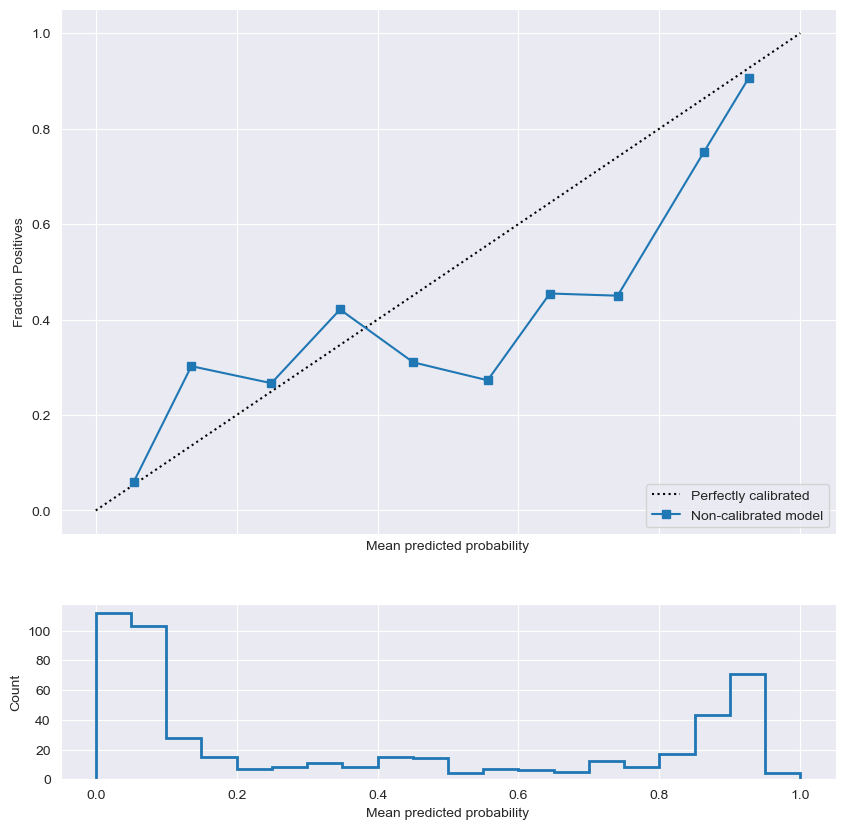

In [18]:
class_0 = (np.array(test_dataset.get_y()) == 0).astype(int)
preds_0 = CM.predict_proba(test_dataset)[:,0]
fig_calib = plot_calib_curve(class_0, preds_0, bins=10)

100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


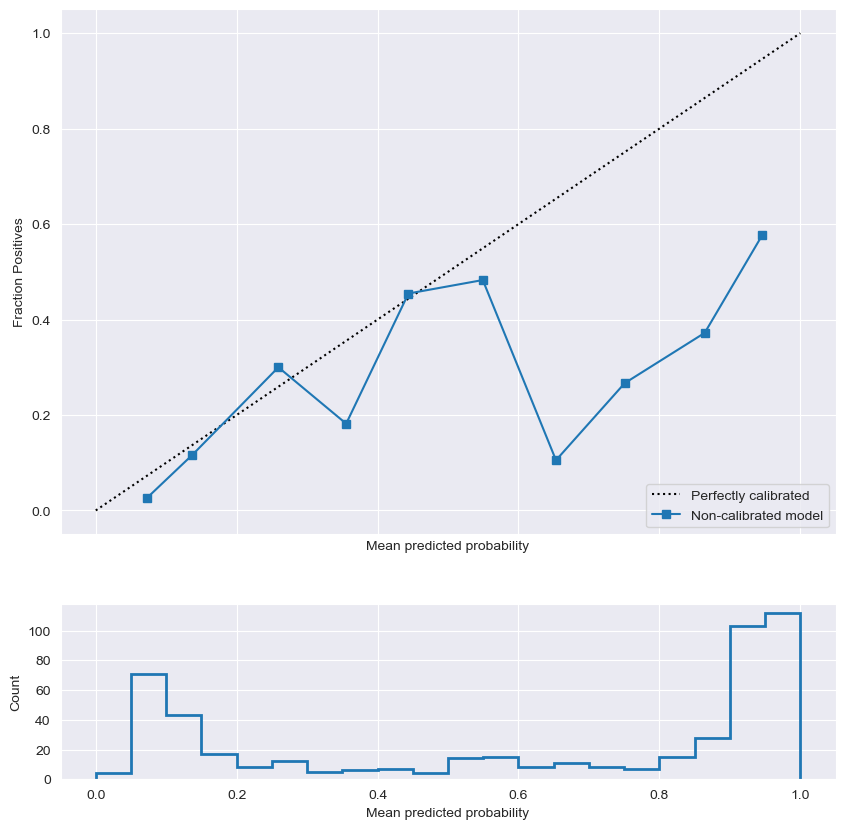

In [19]:
class_2 = (np.array(test_dataset.get_y()) == 2).astype(int)
preds_2 = CM.predict_proba(test_dataset)[:,1]
fig_calib = plot_calib_curve(class_2, preds_2, bins=10)